In [169]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scanpy as sc
import scipy.io as sio
import anndata as ad
import os as os
import seaborn as sns
from load_10X_matrices import load_10X_matrices

In [170]:
#adata = load_10X_matrices('/home/data/ICI_exprs/GSE169246')
#adata = sc.read_10x_mtx('/home/data/ICI_exprs/GSE169246/', var_names='gene_symbols')
adata = sc.read('/home/data/ICI_exprs/GSE169246/GSE169246_TNBC_RNA_matrix.mtx.gz')
print(adata)

--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.
AnnData object with n_obs × n_vars = 27085 × 489490
    obs: ''
    var: ''


In [171]:
#adata = adata.T

In [172]:
#genes = pd.read_csv('/home/data/ICI_exprs/GSE169246/GSE169246_TNBC_RNA_features.tsv.gz', header=None, sep='\t')
#barcodes = pd.read_csv('/home/data/ICI_exprs/GSE169246/GSE169246_TNBC_RNA_barcodes.tsv.gz', header=None)
#adata.obs[''] = barcodes
#adata.var[''] = genes

In [177]:
genes = pd.read_csv('/home/data/ICI_exprs/GSE169246/GSE169246_TNBC_RNA_features.tsv.gz', header=None, sep='\t')
barcodes = pd.read_csv('/home/data/ICI_exprs/GSE169246/GSE169246_TNBC_RNA_barcodes.tsv.gz', header=None)
adata.obs[''] = barcodes
adata.var[''] = genes

In [189]:
adata.obs['sample_id'] = barcodes.reindex(adata.obs.index)[0].values
adata.var['gene_id'] = genes.reindex(adata.var.index)[0].values

In [192]:
barcodes

,0
0,AAACCTGAGGTTACCT.Pre_P007_b
1,AAACCTGCAAAGGAAG.Pre_P007_b
2,AAACCTGCAAGTCTAC.Pre_P007_b
3,AAACCTGCAATAAGCA.Pre_P007_b
4,AAACCTGCACAGCGTC.Pre_P007_b
...,...
489485,TGGTTAGTCACTCTTA.Pre_P004_t
489486,TGTTCCGTCTAACGGT.Pre_P004_t
489487,TTCGAAGCAATCCAAC.Pre_P004_t
489488,TTCTCAATCATCATTC.Pre_P004_t


In [173]:
sample_id = adata.obs['']
short = [x.split('.')[-1] for x in sample_id]
adata.obs['sample_id'] = short
adata.obs['time_point'] = [x.split('_')[0] for x in short]
adata.obs['patient_id'] = [x.split('_')[1][1:] for x in short]

AttributeError: 'float' object has no attribute 'split'

In [ ]:
adata.obs

,,sample_id,time_point,patient_id
0,AAACCTGAGGTTACCT.Pre_P007_b,Pre_P007_b,Pre,007
1,AAACCTGCAAAGGAAG.Pre_P007_b,Pre_P007_b,Pre,007
2,AAACCTGCAAGTCTAC.Pre_P007_b,Pre_P007_b,Pre,007
3,AAACCTGCAATAAGCA.Pre_P007_b,Pre_P007_b,Pre,007
4,AAACCTGCACAGCGTC.Pre_P007_b,Pre_P007_b,Pre,007
...,...,...,...,...
489485,TGGTTAGTCACTCTTA.Pre_P004_t,Pre_P004_t,Pre,004
489486,TGTTCCGTCTAACGGT.Pre_P004_t,Pre_P004_t,Pre,004
489487,TTCGAAGCAATCCAAC.Pre_P004_t,Pre_P004_t,Pre,004
489488,TTCTCAATCATCATTC.Pre_P004_t,Pre_P004_t,Pre,004


In [ ]:
# viewing post treatment patient data ONLY 
post = adata.obs.loc[adata.obs["time_point"] == "Post"]
print(post)

                                        sample_id time_point patient_id
201139  AAACCTGAGATGAGAG.Post_P003_t  Post_P003_t       Post        003
201140  AAACCTGAGCGATCCC.Post_P003_t  Post_P003_t       Post        003
201141  AAACCTGCACATCCAA.Post_P003_t  Post_P003_t       Post        003
201142  AAACCTGGTAGATTAG.Post_P003_t  Post_P003_t       Post        003
201143  AAACCTGTCTGTCTCG.Post_P003_t  Post_P003_t       Post        003
...                              ...          ...        ...        ...
488824  TTTGGTTAGAGCTTCT.Post_P004_b  Post_P004_b       Post        004
488825  TTTGGTTAGTCTTGCA.Post_P004_b  Post_P004_b       Post        004
488826  TTTGTCAGTCCAGTGC.Post_P004_b  Post_P004_b       Post        004
488827  TTTGTCAGTGAGCGAT.Post_P004_b  Post_P004_b       Post        004
488828  TTTGTCATCTTCTGGC.Post_P004_b  Post_P004_b       Post        004

[197637 rows x 4 columns]


In [ ]:
adata.obs_names_make_unique

<bound method AnnData.obs_names_make_unique of AnnData object with n_obs × n_vars = 489490 × 27085
    obs: '', 'sample_id', 'time_point', 'patient_id'
    var: ''>

In [ ]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.9.3 anndata==0.9.1 umap==0.5.3 numpy==1.23.5 scipy==1.10.0 pandas==1.5.3 scikit-learn==1.2.1 statsmodels==0.13.5 python-igraph==0.10.4 pynndescent==0.5.10


In [ ]:
# removing genes expressing in <10 cells
sc.pp.filter_genes(adata, min_cells = 10)

# removing cells with fewer than 400 genes or more than 8000 genes
sc.pp.filter_cells(adata, min_genes=400)
sc.pp.filter_cells(adata, max_genes=8000)

filtered out 4912 genes that are detected in less than 10 cells


/home/wad18/anaconda3/lib/python3.10/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/wad18/anaconda3/lib/python3.10/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


filtered out 4 cells that have less than 400 genes expressed


In [ ]:
# removing cells containing <600 || >120000 UMIs
sc.pp.filter_cells(adata, min_counts = 600)
sc.pp.filter_cells(adata, max_counts = 120000)

In [ ]:
# label genes as mt
adata.var['mt'] = adata.var[''].str.startswith('MT-')  

# annotate cells with the percent of genes assigned as mt
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

# Here we keep cells with < 10% mito ratio
adata = adata[adata.obs['pct_counts_mt'] < 10, :]
adata.shape

(489486, 22173)

In [135]:
# Log normalization scaled up to 10000
sc.pp.normalize_total(adata, target_sum=1e4)

/home/wad18/anaconda3/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


normalizing counts per cell
    finished (0:00:02)


In [136]:
# Logarithmize adata
sc.pp.log1p(adata)

In [137]:
adata.write('/home/data/ICI_exprs/GSE169246/GSE169246_filtered.h5ad')

PermissionError: [Errno 13] Unable to create file (unable to open file: name = '/home/data/ICI_exprs/GSE169246/GSE169246_filtered.h5ad', errno = 13, error message = 'Permission denied', flags = 13, o_flags = 242)

In [ ]:
adata = sc.read_h5ad('/home/data/ICI_exprs/GSE169246/GSE169246_filtered.h5ad')

In [138]:
adata.obs

,,sample_id,time_point,patient_id,n_genes,n_counts,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt
0,AAACCTGAGGTTACCT.Pre_P007_b,Pre_P007_b,Pre,007,818,1769.0,818,1824.501465,28.446278,1.559126
1,AAACCTGCAAAGGAAG.Pre_P007_b,Pre_P007_b,Pre,007,892,3037.0,892,1670.511597,29.680477,1.776730
2,AAACCTGCAAGTCTAC.Pre_P007_b,Pre_P007_b,Pre,007,597,1117.0,597,1536.371338,49.583656,3.227323
3,AAACCTGCAATAAGCA.Pre_P007_b,Pre_P007_b,Pre,007,757,1750.0,757,1695.329834,41.121979,2.425603
4,AAACCTGCACAGCGTC.Pre_P007_b,Pre_P007_b,Pre,007,470,652.0,470,1388.846924,33.881798,2.439563
...,...,...,...,...,...,...,...,...,...,...
489485,TGGTTAGTCACTCTTA.Pre_P004_t,Pre_P004_t,Pre,004,1439,3440.0,1439,2462.848389,42.925385,1.742916
489486,TGTTCCGTCTAACGGT.Pre_P004_t,Pre_P004_t,Pre,004,1449,3855.0,1449,2385.491943,36.198452,1.517442
489487,TTCGAAGCAATCCAAC.Pre_P004_t,Pre_P004_t,Pre,004,2957,9030.0,2957,3299.965332,42.833614,1.298002
489488,TTCTCAATCATCATTC.Pre_P004_t,Pre_P004_t,Pre,004,1253,2519.0,1253,2392.494385,41.771667,1.745946


If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:04)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


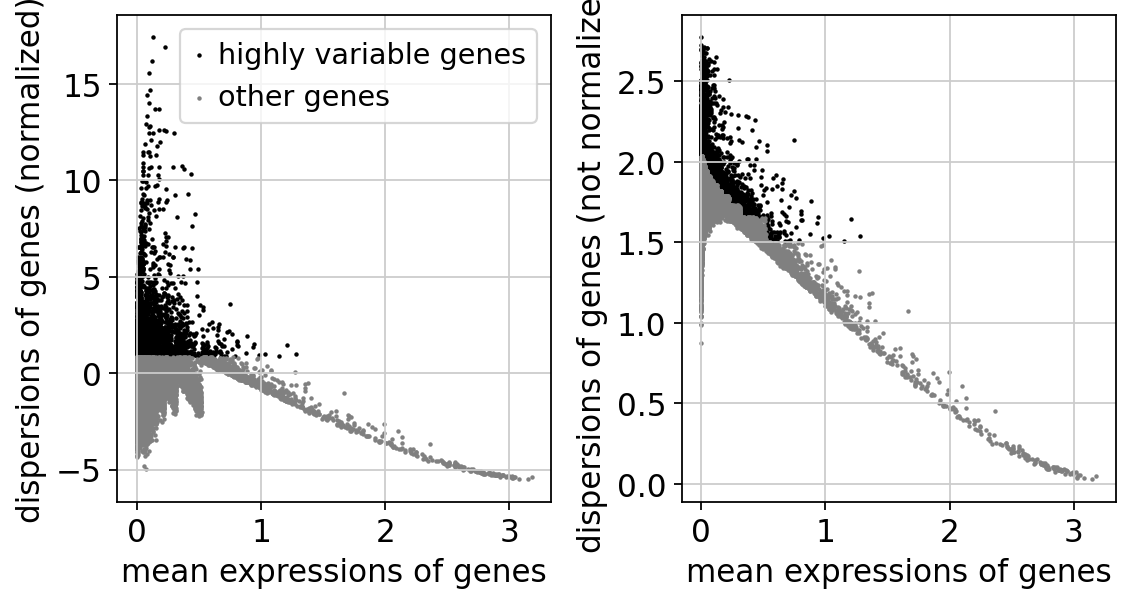

In [139]:
sc.pp.highly_variable_genes(adata, n_top_genes = 4000, flavor = 'cell_ranger')
#sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5, subset=True)
sc.pl.highly_variable_genes(adata)

In [140]:
adata.raw = adata
adata = adata[:, adata.var.highly_variable]
print('adata dimensions of high variance genes: ' + str(adata.shape))

adata dimensions of high variance genes: (489486, 4000)


In [141]:
# perform PCA   
sc.tl.pca(adata, svd_solver='arpack', n_comps=50)

# Keep the top 50 components
#adata.obsm["X_pca"] = adata.obsm["X_pca"][:, :50]

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:46)


In [142]:
print(adata.obsm['X_pca'].shape)
print(adata.varm['PCs'].shape)
print(adata.uns['pca']['variance_ratio'].shape)
print(adata.obs.columns)

(489486, 50)
(4000, 50)
(50,)
Index(['', 'sample_id', 'time_point', 'patient_id', 'n_genes', 'n_counts',
       'n_genes_by_counts', 'total_counts', 'total_counts_mt',
       'pct_counts_mt'],
      dtype='object')


In [143]:
sc.pp.neighbors(adata, n_neighbors=80, n_pcs=50)
#sc.external.pp.bbknn(adata, batch_key='batch', n_pcs=50)

computing neighbors
    using 'X_pca' with n_pcs = 50


KeyboardInterrupt: 

In [ ]:
# Use the Leiden algorithm to find clusters
sc.tl.leiden(adata)
#sc.tl.leiden(adata, resolution=0.5)

running Leiden clustering
    finished: found 21 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:02)


ranking genes


/home/wad18/anaconda3/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:394: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/home/wad18/anaconda3/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
/home/wad18/anaconda3/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:399: PerformanceWarning: DataFrame is highly fragme

    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:14)


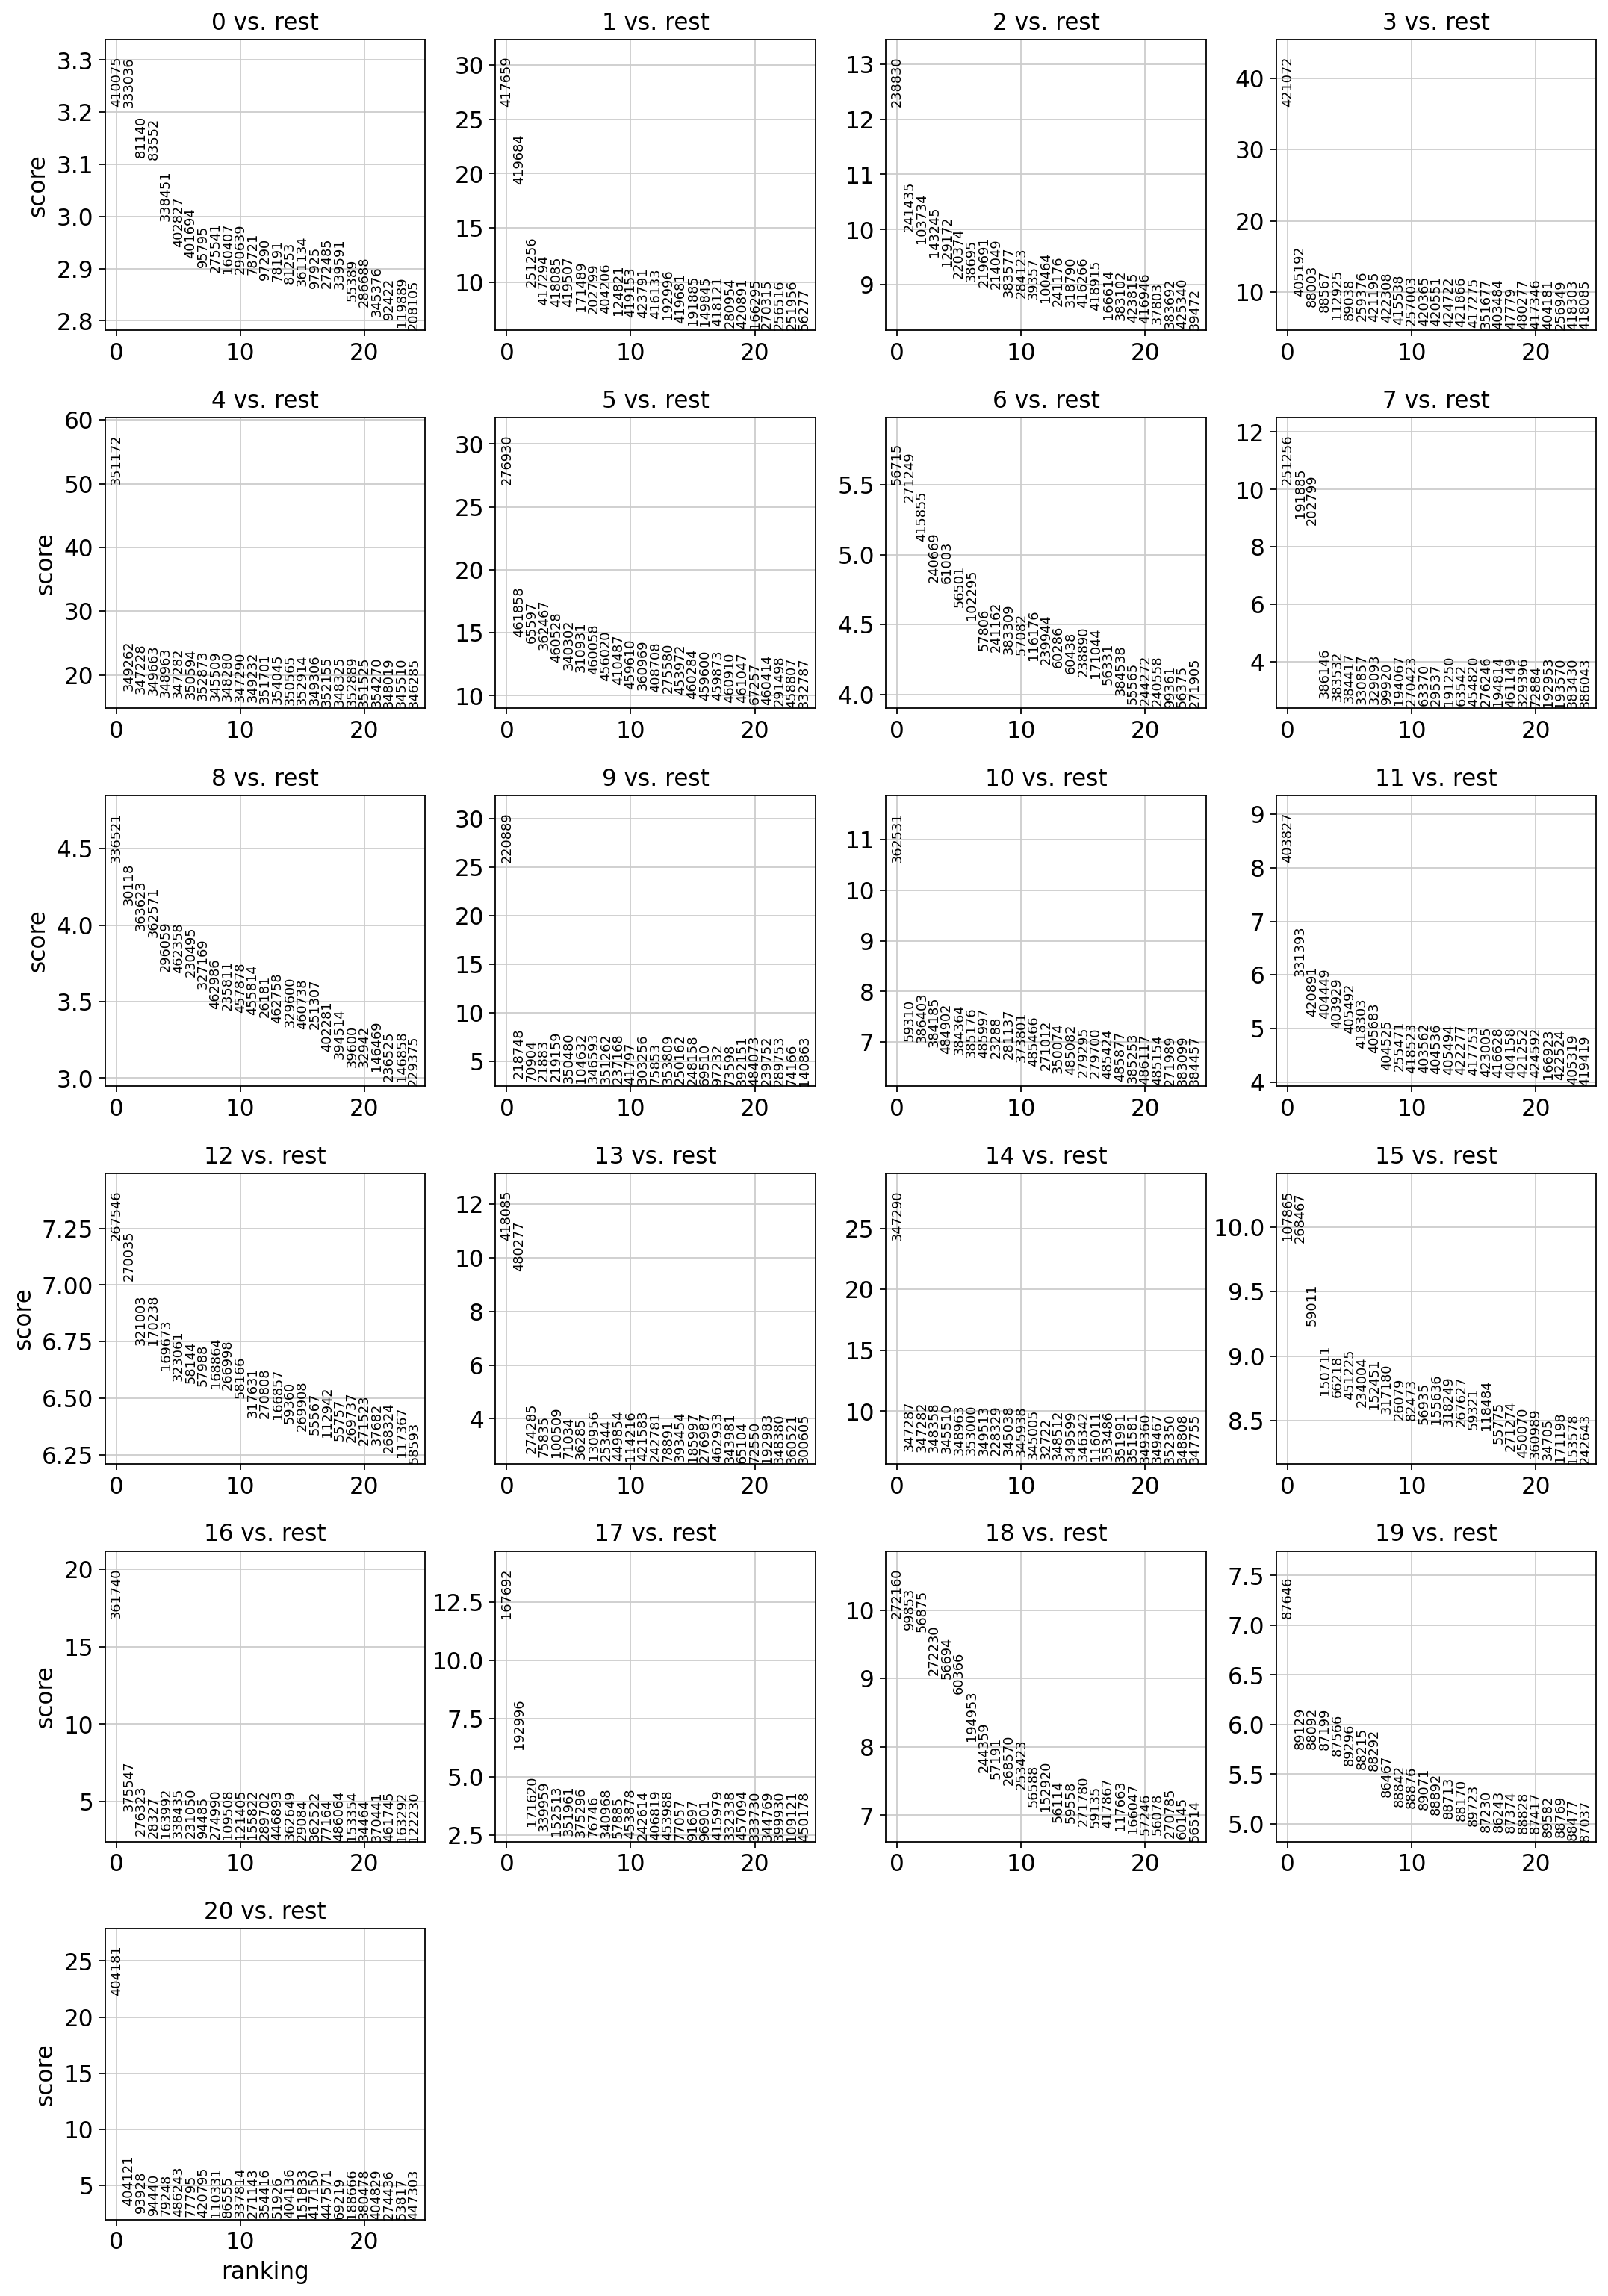

In [ ]:
# load/find cell cycle markers: T-test/T-cells
sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:11)


/home/wad18/anaconda3/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


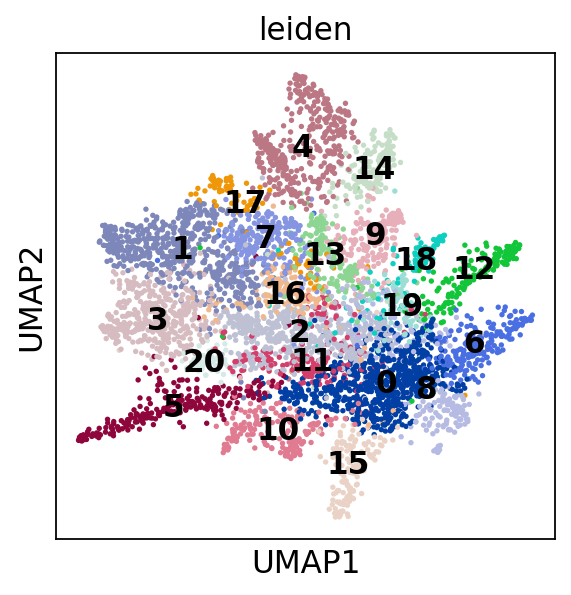

In [ ]:
# perform UMAP
sc.tl.umap(adata)
sc.pl.umap(adata, color='leiden',legend_loc='on data')

In [ ]:
# find marker genes of each cluster
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')

ranking genes


/home/wad18/anaconda3/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:394: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/home/wad18/anaconda3/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
/home/wad18/anaconda3/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:399: PerformanceWarning: DataFrame is highly fragme

    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:02:09)


In [ ]:
t_cell_markers = {  
    'CD3'	: ['CD3G', 'CD40LG', 'ZNF683'],
    'CD4'	: ['CD4', 'ICOS', 'HAVCR2', 'RORA'],
    'CD8'	: ['TOX2', 'ITGAE', 'LAG3','CD81'], 
    'Naïve'	: ['SELL', 'TCF7', 'LEF1', 'IL7R'],  
    'Exhausted' : ['PDCD1', 'TIGIT', 'CTLA4'],
    'Cytotoxic' : ['GZMK', 'GNLY', 'GZMB', 'PRF1', 'NKG7'],
    'Treg' : ['FOXP3', 'IL2RA', 'TIGIT', 'CTLA4', 'LAYN'], 
    'Th17' : ['KLRB1'],
    'MAIT' : ['KLRB1', 'IL7R'],  
    'Th1' :	['IFNG'],
    'Tfh'	: ['CXCL13', 'PDCD1'],
    'NK' :  ['NKG7', 'GNLY', 'GZMB', 'KLRG1', 'KLRB1','XCL1'],
    'Fibroblast' : ['FGFBP2']
}

In [ ]:
t_cell_markers = {
    'CD4'	: ['CD4', 'IL7R'],
    'CD8'	: [ 'CD8A', 'CD8B'],
    'Naïve'	: ['TCF7', 'SELL', 'LEF1', 'CCR7'],
    'Exhausted' : ['LAG3', 'TIGIT', 'PDCD1', 'HAVCR2', 'CTLA4'],
    'Cytotoxic' : ['IL2', 'GZMA', 'GNLY', 'PRF1', 'GZMB', 'GZMK', 'IFNG', 'NKG7'],
    'Treg' : ['IL2RA', 'FOXP3', 'IKZF2', 'IKZF4',  'TNFRSF18'],
    'Th17' : ['IL17A',  'CCR6', 'KLRB1'],  #'IL22',
    'MAIT' : ['SLC4A10', 'KLRB1', 'IL7R', 'DPP4'],  
    'ILC' :	['KIT', 'IL1R1'],
    'Th1' :	['STAT4', 'IL12RB2', 'IFNG'],
    'Th2' :	['GATA3', 'STAT6', 'IL4'],
    'Tfh'	: ['MAF', 'CXCL13', 'CXCR5', 'PDCD1'],
    'NK' :  ['XCL1', 'FCGR3A', 'KLRD1', 'KLRF1', 'NCAM1'],
    'Proliferation' : ['MKI67', 'PCNA', 'STMN1']
}

In [ ]:
adata.raw.var_names

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
       ...
       '489480', '489481', '489482', '489483', '489484', '489485', '489486',
       '489487', '489488', '489489'],
      dtype='object', length=489490)

In [ ]:
# check if the markers are in the var names
for cell_type, markers in t_cell_markers.items():
    print (cell_type, ":", markers)
    print ("number of match in var: ", str(sum(adata.raw.var_names.isin(markers))))

CD4 : ['CD4', 'IL7R']
number of match in var:  0
CD8 : ['CD8A', 'CD8B']
number of match in var:  0
Naïve : ['TCF7', 'SELL', 'LEF1', 'CCR7']
number of match in var:  0
Exhausted : ['LAG3', 'TIGIT', 'PDCD1', 'HAVCR2', 'CTLA4']
number of match in var:  0
Cytotoxic : ['IL2', 'GZMA', 'GNLY', 'PRF1', 'GZMB', 'GZMK', 'IFNG', 'NKG7']
number of match in var:  0
Treg : ['IL2RA', 'FOXP3', 'IKZF2', 'IKZF4', 'TNFRSF18']
number of match in var:  0
Th17 : ['IL17A', 'CCR6', 'KLRB1']
number of match in var:  0
MAIT : ['SLC4A10', 'KLRB1', 'IL7R', 'DPP4']
number of match in var:  0
ILC : ['KIT', 'IL1R1']
number of match in var:  0
Th1 : ['STAT4', 'IL12RB2', 'IFNG']
number of match in var:  0
Th2 : ['GATA3', 'STAT6', 'IL4']
number of match in var:  0
Tfh : ['MAF', 'CXCL13', 'CXCR5', 'PDCD1']
number of match in var:  0
NK : ['XCL1', 'FCGR3A', 'KLRD1', 'KLRF1', 'NCAM1']
number of match in var:  0
Proliferation : ['MKI67', 'PCNA', 'STMN1']
number of match in var:  0


In [ ]:
sc.tl.dendrogram(adata, groupby='leiden')
sc.pl.dotplot(adata, t_cell_markers, 'leiden', dendrogram=True)

    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_leiden']`


KeyError: "Could not find keys '['CD3G', 'CD4', 'CD40LG', 'CD81', 'CTLA4', 'CXCL13', 'FGFBP2', 'FOXP3', 'GNLY', 'GZMB', 'GZMK', 'HAVCR2', 'ICOS', 'IFNG', 'IL2RA', 'IL7R', 'ITGAE', 'KLRB1', 'KLRG1', 'LAG3', 'LAYN', 'LEF1', 'NKG7', 'PDCD1', 'PRF1', 'RORA', 'SELL', 'TCF7', 'TIGIT', 'TOX2', 'XCL1', 'ZNF683']' in columns of `adata.obs` or in adata.raw.var_names."

In [ ]:
for cell_type, markers in t_cell_markers.items():
    print(cell_type, ":", "markers")
    sc.pl.umap(adata, color=markers)